# Zoiberg-2.0 Bootstrap


In [1]:
# Just to make sure my RAM doesn't explode, clears all variables in memory
%reset

## Imports

---


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Take a small percentage of data to speed up tests !
PERCENTAGE_OF_DATA = 5 / 100

In [4]:
df_train = pd.read_csv('./mnist_train.csv', header=None)
df_test = pd.read_csv('./mnist_test.csv', header=None)
df_train = df_train.iloc[:int(df_train.shape[0] * PERCENTAGE_OF_DATA), :]
df_test = df_test.iloc[:int(df_test.shape[0] * PERCENTAGE_OF_DATA), :]


In [5]:
print(f'Train set shape: {df_train.shape}')
print(f'Test set shape: {df_test.shape}')
df_train.head()
# df_test.head()

Train set shape: (3000, 785)
Test set shape: (500, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_train = df_train.rename(columns={0: 'digit'})
df_test = df_test.rename(columns={0: 'digit'})

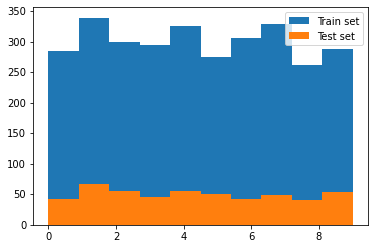

In [7]:
plt.hist(df_train['digit'], label='Train set')
plt.hist(df_test['digit'], label='Test set')
plt.legend()

In [8]:
def show_image(n_image):
    pixels = df_train.drop('digit', axis=1).iloc[n_image].values
    img = np.reshape(pixels, (28, 28))
    plt.imshow(img, cmap='plasma')


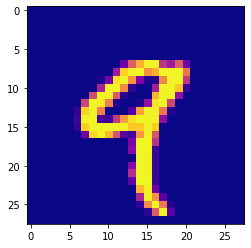

In [9]:
show_image(4)

In [10]:
df_train['digit'].describe()

count    3000.000000
mean        4.434000
std         2.849272
min         0.000000
25%         2.000000
50%         4.000000
75%         7.000000
max         9.000000
Name: digit, dtype: float64

In [11]:
pd.concat([
    df_train['digit'].value_counts().sort_index().rename('Train'),
    df_test['digit'].value_counts().sort_index().rename('Test')
],
          axis=1)


,Train,Test
0,285,42
1,339,67
2,299,55
3,295,45
4,325,55
5,274,50
6,306,43
7,329,49
8,261,40
9,287,54


In [12]:
def plot_data_distribution(df, df_name, fig_name, savefig=False):
    plt.rcParams.update({'font.size': 22})

    fig = plt.figure(figsize=(16, 8))
    hist = sns.countplot(data=df, x='digit', saturation=1, color='lightblue')

    patch_h = [patch.get_height() for patch in hist.patches]
    # patch_h contains the heights of all the patches now

    # np.argmax return the index of largest value of the list
    idx_tallest = np.argmax(patch_h)
    idx_smallest = np.argmin(patch_h)

    hist.patches[idx_tallest].set_facecolor('orangered')
    hist.patches[idx_smallest].set_facecolor('gold')
    hist.bar_label(hist.containers[0], padding=-30)
    hist.set_title(df_name)
    hist.set_frame_on(False)
    hist.get_yaxis().set_visible(False)
    hist.set_xlabel('')

    if savefig:
        fig.add_axes(hist)
        fig.savefig(f'graphs/{fig_name}.png', facecolor='white')

    plt.rcParams.update({'font.size': 10})


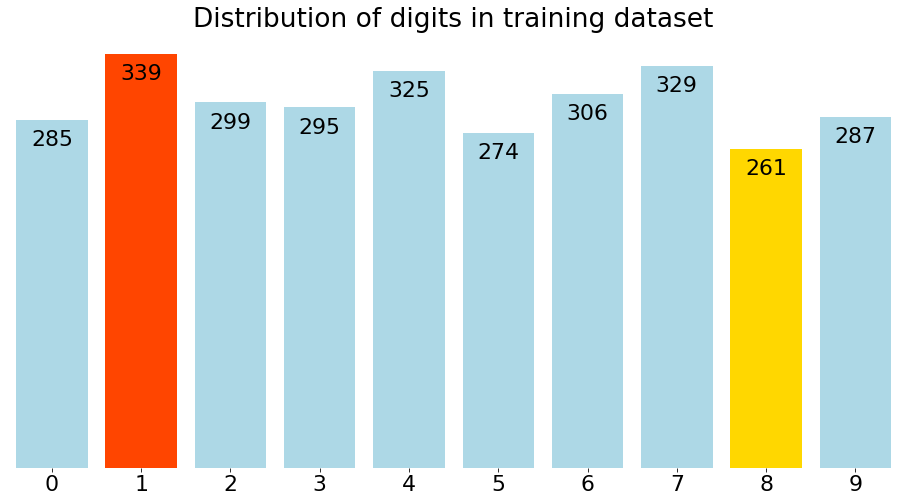

In [13]:
plot_data_distribution(df_train, 'Distribution of digits in training dataset',
                       'digit_distribution_train_set')


As we can see the digits are pretty much envenly distributed throughout the training dataset. What about the test set ?


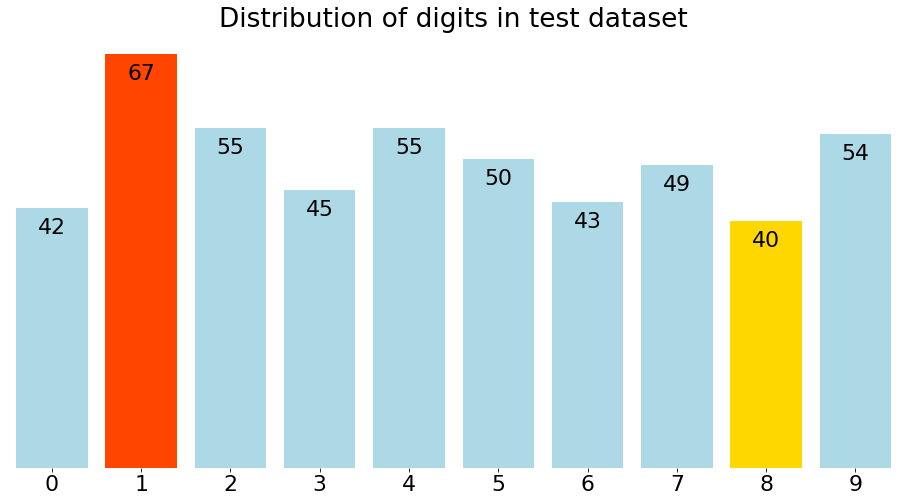

In [14]:
plot_data_distribution(df_test, 'Distribution of digits in test dataset',
                       'digit_distribution_test_set')


We can see that values in the test set are also evenly distributed


## Predictions

---


In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve, learning_curve, GridSearchCV

In [16]:
model = KNeighborsClassifier()

In [17]:
y_train = df_train['digit']
X_train = df_train.drop('digit', axis=1)
y_test = df_test['digit']
X_test = df_test.drop('digit', axis=1)

In [18]:
model.fit(X_train, y_train)

KNeighborsClassifier()

In [19]:
print(f'Train score: {model.score(X_train, y_train)}')
print(f'Test score: {model.score(X_test, y_test)}')

Train score: 0.9426666666666667
Test score: 0.89


In [20]:
model = KNeighborsClassifier()
k = np.arange(1, 50)

# WARNING: this line takes forever to compile, maybe reduce the sample size to speed up the process ?
train_score, val_score = validation_curve(model,
                                          X_train,
                                          y_train,
                                          param_name='n_neighbors',
                                          param_range=k,
                                          cv=5)


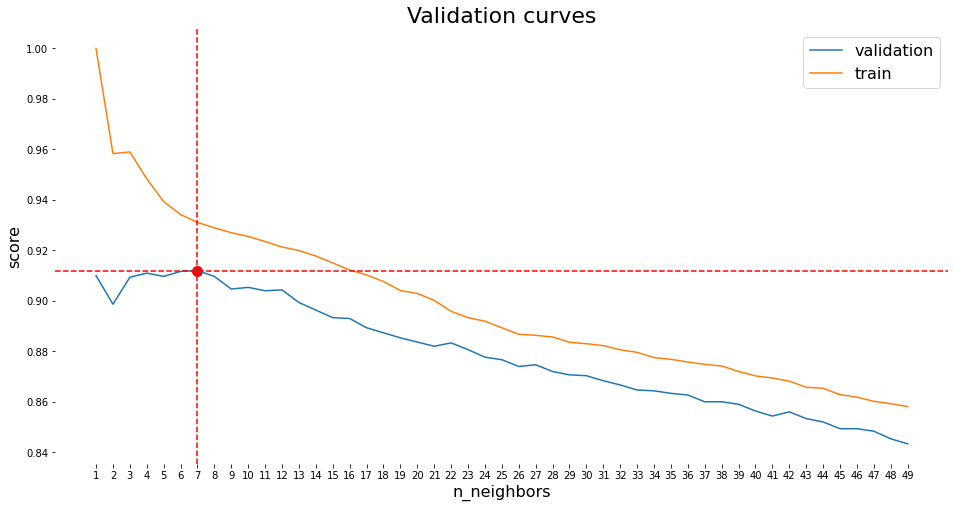

In [21]:
val_score_mean = val_score.mean(axis=1)

plt.figure(figsize=(16, 8))
plt.title('Validation curves', fontsize=22)
plt.box(False)
plt.plot(k, val_score_mean, label='validation')
plt.plot(k, train_score.mean(axis=1), label='train')
plt.axhline(val_score_mean.max(), c='red', linestyle='--')
plt.axvline(val_score_mean.argmax() + 1, c='red', linestyle='--')
plt.scatter(val_score_mean.argmax() + 1,
            val_score_mean.max(),
            c='red',
            linewidths=5)
plt.xticks(k)

plt.xlabel('n_neighbors', fontsize=16)
plt.ylabel('score', fontsize=16)
plt.legend(fontsize=16)
# plt.savefig('graphs/validation_curves.png', facecolor='white')

In [22]:
model = KNeighborsClassifier(7)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.872

Hmm, interesting to see that changing n_neighbors actually **decreased** our accuracy. But it's not so surprinsing when looking at the validation curves (KNN default value for n_neighbors is 5 and we can see on the curves that the score for n_neighbors=5 and n_neighbors=7 are really close)

Let's see if taking into account all of the data is useful through learning curves:


In [23]:
N, train_score, val_score = learning_curve(model,
                                           X_train,
                                           y_train,
                                           train_sizes=np.linspace(.1, 1, 10),
                                           cv=5)


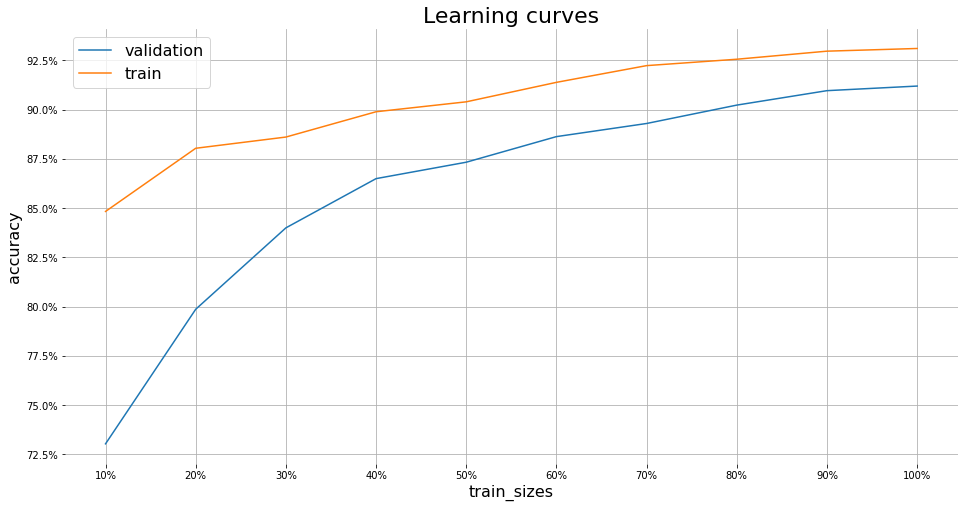

In [24]:
import matplotlib.ticker as mtick

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot()

ax.plot(np.linspace(.1, 1, 10), val_score.mean(axis=1), label='validation')
ax.plot(np.linspace(.1, 1, 10), train_score.mean(axis=1), label='train')

ax.set_title('Learning curves', fontsize=22)
ax.set_xlabel('train_sizes', fontsize=16)
ax.set_ylabel('accuracy', fontsize=16)
ax.set_xticks(np.linspace(.1, 1, 10))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.legend(fontsize=16)

ax.set_frame_on(False)
ax.grid()

# fig.savefig('graphs/learning_curves.png', facecolor='white')

It doesn't seem like we are in a situation of overfitting : the more data the better the precision of our model

Let's see if changing hyperparameters of KNN does improve it's accuracy:


In [25]:
param_grid = {
    'n_neighbors': np.arange(3, 10),
    'metric': ['euclidean', 'manhattan', 'minkowski', 'cosine']
}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski',
                                    'cosine'],
                         'n_neighbors': array([3, 4, 5, 6, 7, 8, 9])})

In [26]:
print(f'GridSearchCV Best parameters: {grid.best_params_}')
best_estimator = grid.best_estimator_
print(f'Best estimator score: {best_estimator.score(X_test, y_test)}')

GridSearchCV Best parameters: {'metric': 'cosine', 'n_neighbors': 5}
Best estimator score: 0.922


Actually a pretty significant upgrade in accuracy !


<center>
  <img src="./assets/accuracy.png" alt="Accuracy" width=728 height=454>
  <h4><i>Accuracy definition</i></h4>
</center>


## Questions

---


### 1. _Why use a separate dataset to measure the performance of an algorithm?<br> What are the results you get when you test your algorithm on the same dataset used in training?_


It's important to separate the dataset into two groups:

- the **train** set, to train our model
- the **test** set, to evaluate the performance of our model

If we don't do that and test our algorithm on the same dataset used in training, we would get an inaccurate evaluation of the performance of our model, since it has already seen all of the data. The idea behind the test set is to confront and evaluate our model on real life data, or at least on data that the model had not seen before.


### 2. _What are bias and variance?<br> What do they measure?<br> Which values should they take?_


**Bias** is the difference between the average prediction of our model and the correct value which we are trying to predict. Model with high bias pays very little attention to the training data and oversimplifies the model. It always leads to high error on training and test data.

**Variance** is the variability of model prediction for a given data point or a value which tells us spread of our data. Model with high variance pays a lot of attention to training data and does not generalize on the data which it hasn’t seen before. As a result, such models perform very well on training data but has high error rates on test data.

<center>
  <img src="./assets/bias_and_variance.png" alt="Bias and variance">
  <h4><i>Bias and variance</i></h4>
  <img src="./assets/bias_variance_balance.png" alt="Bias and variance balance">
  <h4><i>Bias and variance balance</i></h4>
</center>


### _3. What is cross validation?<br>What are the main advantages?<br>When can I use it?_


Cross-validation is a statistical technique for assessing the effectiveness of machine learning models, particularly in cases where we need to mitigate overfitting. It is also of use in determining the hyper parameters of machine learning models, in the sense that which parameters will result in lowest test error.

The only possible drawback of this method is that as we gain robustness by increasing the number of splits, we also have to train more model — a potentially tedious and expensive process.


### _4. Can you explain why it’s important to normalize (i.e. scale) the data when using algorithms like KNN?<br>Is it necessary in our specific study case?_


KNN is a distance based algorithms. KNN chooses the k closest neighbors and then based on these neighbors, assigns a class (for classification problems) or predicts a value (for regression problems) for a new observation.

All such distance based algorithms are affected by the scale of the variables which is why it is always advisable to bring all the features to the same scale **before** applying distance based algorithms like KNN.


So, let's try to preprocess our data before using the KNN algorithm:


In [27]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

In [28]:
model = make_pipeline(MinMaxScaler(), KNeighborsClassifier())
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.89

In [29]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.89

As we can see the preprocessing had no effect on our model :(


### 5. _When you reshaped your image, do you think the order of the columns (that means the order of the pixels) had an importance for the performance of your algorithm?_


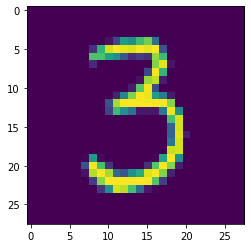

In [30]:
plt.imshow(X_train.values.reshape(X_train.shape[0], 28, 28)[50])

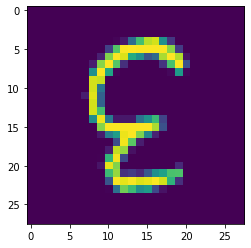

In [31]:
X_train_reversed = X_train.values[:, ::-1]
X_test_reversed = X_test.values[:, ::-1]
plt.imshow(X_train_reversed.reshape(X_train_reversed.shape[0], 28, 28)[50])

In [32]:
model = KNeighborsClassifier()
model.fit(X_train_reversed, y_train)
model.score(X_test_reversed, y_test)

0.89

As long as we apply the **same** transformation to both the train and the test set on all of their images, it seems that it does **not** affect the performance of our model


### 6. _Which metrics measure performance?<br>What does accuracy tell you?<br>Does accuracy penalize more one mistake over another?_


In [33]:
from sklearn.metrics import *

In [34]:
def evaluate_model(model):
    y_pred = model.predict(X_test)
    print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}')
    print(
        f'Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred))}'
    )
    print(
        f'Median Absolute Error: {np.sqrt(median_absolute_error(y_test, y_pred))}'
    )
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted')}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted')}")
    print(f"F1: {f1_score(y_test, y_pred, average='weighted')}\n\n")


In [35]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

print(f"DIFFERENT PERFORMANCE METRICS FOR BASIC KNN MODEL\n{'-'*20}")
evaluate_model(model)
print(
    f"DIFFERENT PERFORMANCE METRICS FOR KNN MODEL AFTER GRIDSEARCHCV\n{'-'*20}"
)
evaluate_model(best_estimator)

DIFFERENT PERFORMANCE METRICS FOR BASIC KNN MODEL
--------------------
Mean Absolute Error: 0.336
Root Mean Squared Error: 1.2033287165193058
Median Absolute Error: 0.0
Accuracy: 0.89
Precision: 0.8938556616586028
Recall: 0.89
F1: 0.8887776004511299


DIFFERENT PERFORMANCE METRICS FOR KNN MODEL AFTER GRIDSEARCHCV
--------------------
Mean Absolute Error: 0.268
Root Mean Squared Error: 1.1331372379372235
Median Absolute Error: 0.0
Accuracy: 0.922
Precision: 0.9255718433868829
Recall: 0.922
F1: 0.921800801484119




Accuracy is the ratio of number of correct predictions to the total number of input samples. It works well only if there are equal number of samples belonging to each class, as it does not penalizeke over another.


### 7. _Can you give an explicit example where accuracy would not be a relevant metric?<br>In that extreme case, can you propose a more suitable metric?_


Consider that there are 98% samples of class A and 2% samples of class B in our training set. Then our model can easily get 98% training accuracy by simply predicting every training sample belonging to class A.

When the same model is tested on a test set with 60% samples of class A and 40% samples of class B, then the test accuracy would drop down to 60%. Classification Accuracy is great, but gives us the false sense of achieving high accuracy.

The real problem arises, when the cost of misclassification of the minor class samples are very high. If we deal with a rare but fatal disease, the cost of failing to diagnose the disease of a sick person is much higher than the cost of sending a healthy person to more tests.

Logarithmic Loss or **Log Loss**, works by **penalising the false classifications**. It works well for multi-class classification. When working with Log Loss, the classifier must assign probability to each class for all the samples. In general, minimising Log Loss gives greater accuracy for the classifier.


### 8. _Do confusion matrix display all informations of algorithms’ learning?_


Confusion Matrix as the name suggests gives us a matrix as output and describes the complete performance of the model. It forms the basis for the other types of metrics (Precision, Recall, F1, ROC, AUC).


### 9. _Do you want to have a walk in the forest and observe tree growth?_


Hum.. Sure? I guess ?


## Visualizations

---


In [36]:
y_pred = best_estimator.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[42,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 67,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1, 50,  1,  0,  0,  0,  2,  0,  0],
       [ 0,  0,  1, 42,  0,  0,  0,  2,  0,  0],
       [ 1,  1,  0,  0, 49,  0,  1,  0,  0,  3],
       [ 1,  0,  0,  3,  0, 44,  1,  0,  0,  1],
       [ 2,  0,  0,  0,  0,  1, 40,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0, 47,  0,  1],
       [ 2,  0,  0,  1,  0,  1,  1,  2, 32,  1],
       [ 1,  0,  0,  0,  2,  0,  0,  2,  1, 48]])

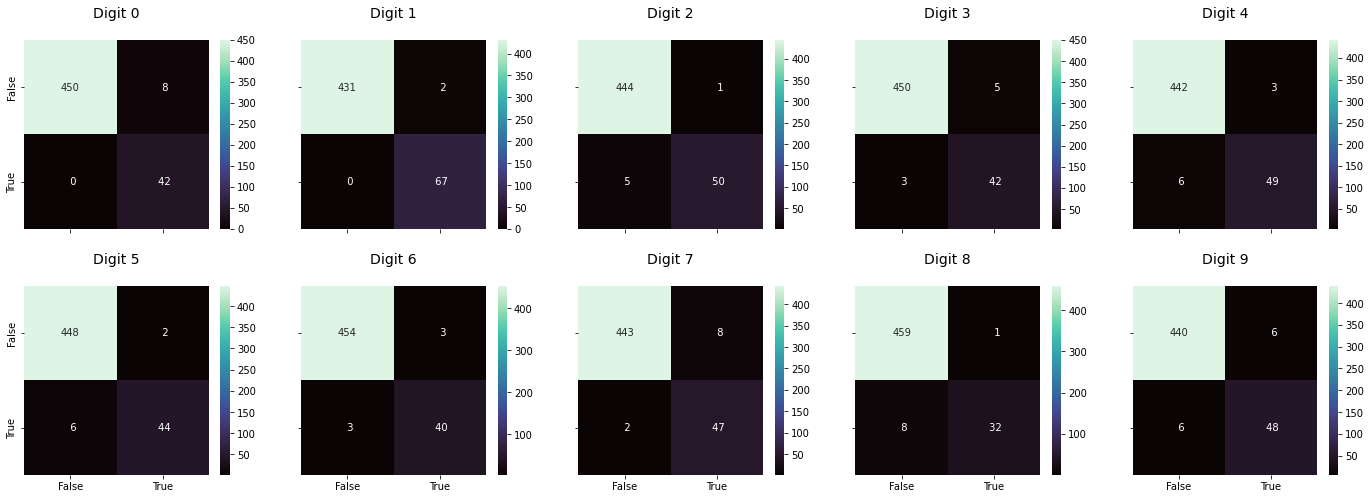

In [37]:
cf_multi_matrix = multilabel_confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(2,
                       5,
                       sharex=True,
                       sharey=True,
                       figsize=(24, 8),
                       gridspec_kw={
                           'wspace': .2,
                           'hspace': .3
                       })
for i, matrix in enumerate(cf_multi_matrix):
    index = (0, i) if i < 5 else (1, i - 5)
    sns.heatmap(data=matrix, ax=ax[index], annot=True, fmt='3', cmap='mako')
    ax[index].set_title(f'Digit {i}\n', fontsize=14)
    ax[index].xaxis.set_ticklabels(['False', 'True'])
    ax[index].yaxis.set_ticklabels(['False', 'True'])
fig.savefig('graphs/multilabel_confusion_matrix.png', facecolor='white')

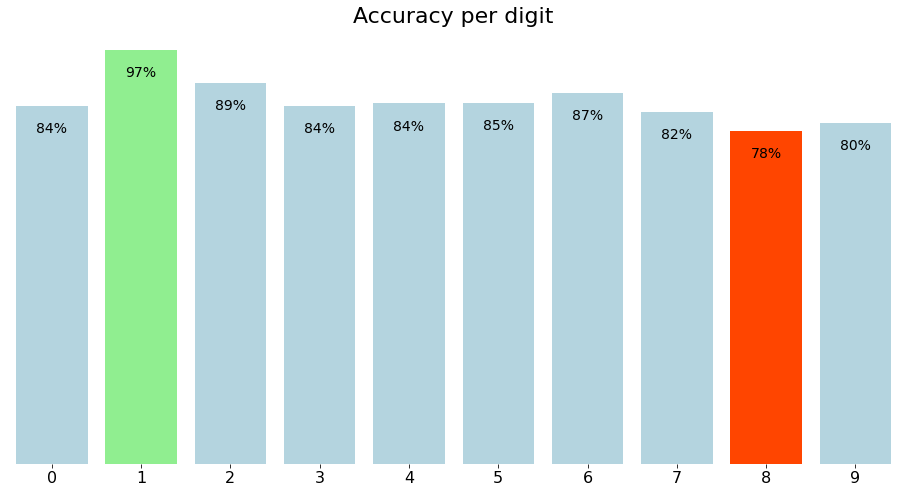

In [38]:
accuracy_arr = np.array([(matrix[1, 1]) / (np.sum(matrix) - matrix[0, 0])
                         for matrix in cf_multi_matrix])

fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=np.arange(accuracy_arr.size),
            y=accuracy_arr * 100,
            ax=ax,
            color='lightblue')

patch_h = [patch.get_height() for patch in ax.patches]
idx_tallest = np.argmax(patch_h)
idx_smallest = np.argmin(patch_h)

ax.patches[idx_tallest].set_facecolor('lightgreen')
ax.patches[idx_smallest].set_facecolor('orangered')
ax.bar_label(ax.containers[0], padding=-30, fmt='%.0f%%', fontsize=14)
ax.set_title('Accuracy per digit', fontsize=22)

ax.get_yaxis().set_visible(False)
ax.set_xlabel('')
ax.set_xticklabels(np.arange(accuracy_arr.size), fontsize=16)

ax.set_frame_on(False)

fig.savefig('graphs/accuracy_per_digit.png', facecolor='white')

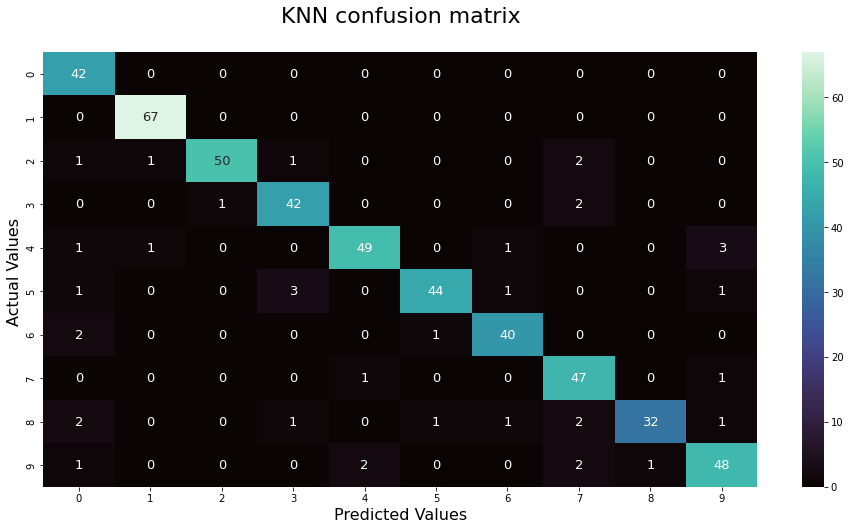

In [39]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(data=cf_matrix,
            ax=ax,
            annot=True,
            cmap='mako',
            annot_kws={'size': 13})
ax.set_title('KNN confusion matrix\n', fontsize=22)
ax.set_xlabel('Predicted Values', fontsize=16)
ax.set_ylabel('Actual Values ', fontsize=16)
fig.savefig('graphs/KNN_confusion_matrix.png', facecolor='white')

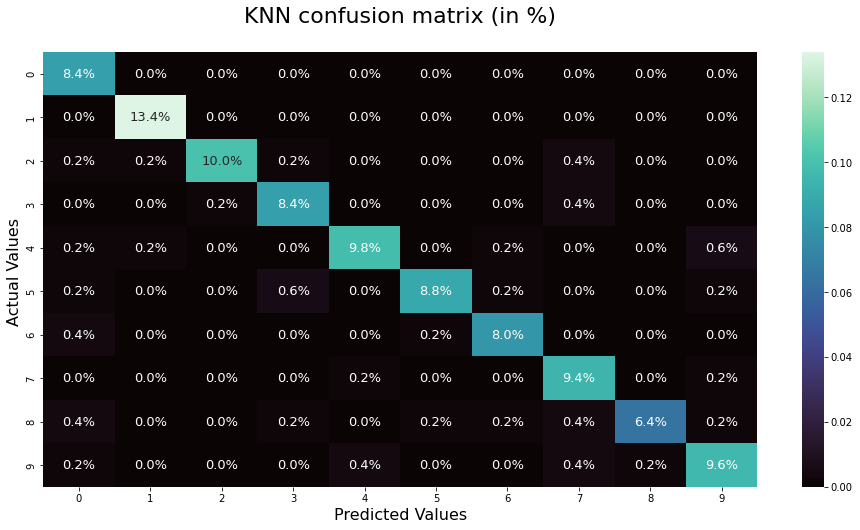

In [40]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(cf_matrix / np.sum(cf_matrix),
            annot=True,
            fmt='.1%',
            cmap='mako',
            annot_kws={'size': 13})
ax.set_title('KNN confusion matrix (in %)\n', fontsize=22)
ax.set_xlabel('Predicted Values', fontsize=16)
ax.set_ylabel('Actual Values ', fontsize=16)
fig.savefig('graphs/KNN_confusion_matrix_percentage.png', facecolor='white')

## UNSUPERVISED LEARNING

---


### Clustering


In [41]:
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [42]:
model = KMeans(n_clusters=10)
model.fit(X_train)

KMeans(n_clusters=10)

In [43]:
inertia = [KMeans(n_clusters=k).fit(X_train).inertia_ for k in range(1, 20)]

Text(0, 0.5, 'Inertia')

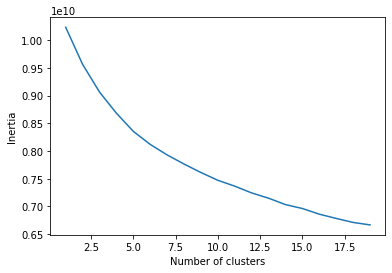

In [44]:
plt.plot(range(1, 20), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

### Anomaly detection


In [45]:
model = IsolationForest()
model.fit(X_train)

IsolationForest()

In [46]:
outliers = model.predict(X_train) == -1
no_outliers = model.predict(X_train) == 1

In [47]:
X_train_filtered = X_train[no_outliers]
y_train_filtered = y_train[no_outliers]

In [48]:
model = KNeighborsClassifier()
model.fit(X_train_filtered, y_train_filtered)
model.score(X_test, y_test)

0.894

We can observe slightly better results when removing outliers from the dataset.


### Dimension Reduction


In [49]:
model = PCA(n_components=2)
X_train_filtered = model.fit_transform(X_train)
X_train_filtered = pd.DataFrame(X_train_filtered, columns=['x', 'y'])

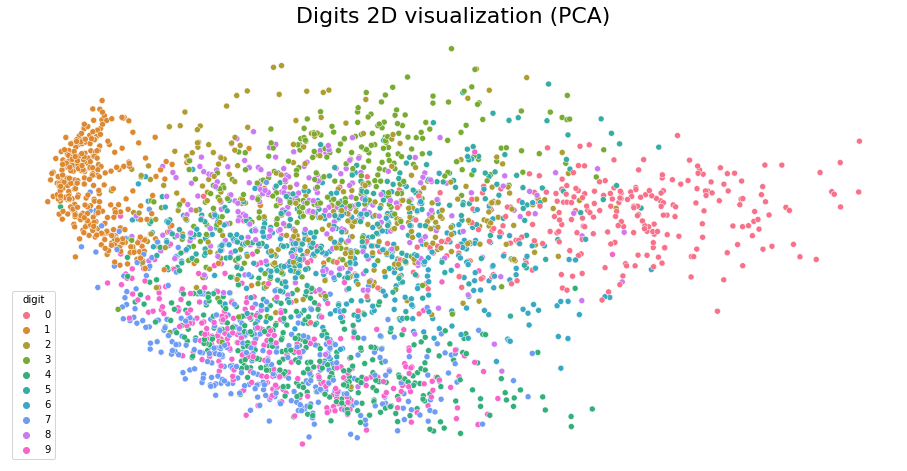

In [50]:
plt.figure(figsize=(16, 8))
ax = sns.scatterplot(data=X_train_filtered,
                     x='x',
                     y='y',
                     hue=y_train,
                     palette=sns.color_palette('husl', 10))
ax.set_title('Digits 2D visualization (PCA)', fontsize=22)
ax.set_axis_off()
# plt.savefig('graphs/digits_2d_visualization_PCA.png', facecolor='white')

In [51]:
model = TSNE(perplexity=50)
X_train_filtered = model.fit_transform(X_train)
X_train_filtered = pd.DataFrame(X_train_filtered, columns=['x', 'y'])

/home/apinotfound/.virtualenvs/zoidberg-bootstrap/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/apinotfound/.virtualenvs/zoidberg-bootstrap/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


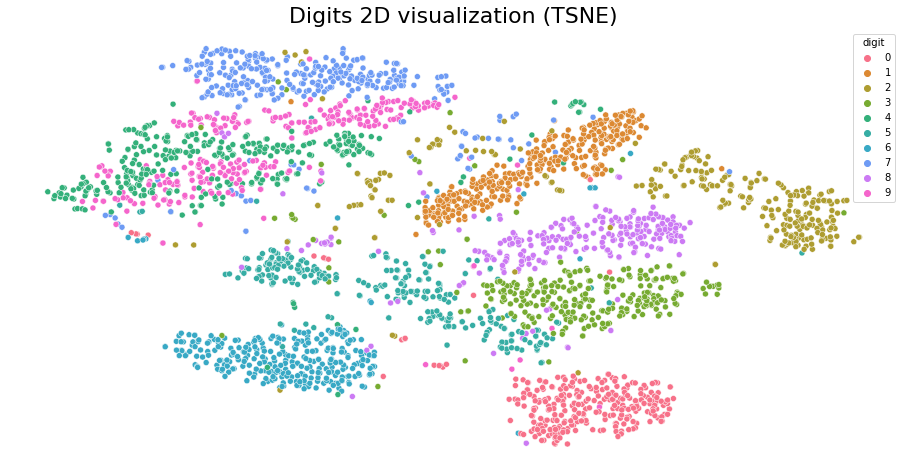

In [52]:
plt.figure(figsize=(16, 8))
ax = sns.scatterplot(data=X_train_filtered,
                     x='x',
                     y='y',
                     hue=y_train,
                     palette=sns.color_palette('husl', 10))
ax.set_title('Digits 2D visualization (TSNE)', fontsize=22)
ax.set_axis_off()
# plt.savefig('graphs/digits_2d_visualization_TSNE.png', facecolor='white')

In [53]:
model = PCA(n_components=X_train.shape[1])
X_train_filtered = model.fit_transform(X_train)

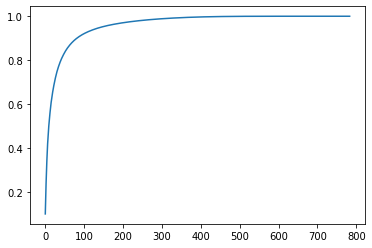

In [54]:
plt.plot(np.cumsum(model.explained_variance_ratio_))

In [55]:
model = PCA(n_components=.95)
X_train_filtered = model.fit_transform(X_train)
model.n_components_

145

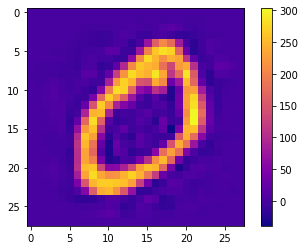

In [56]:
X_train_recovered = model.inverse_transform(X_train_filtered)
plt.imshow(X_train_recovered[1].reshape(28, 28), cmap='plasma')
plt.colorbar()

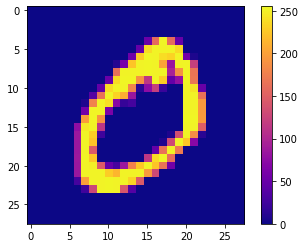

In [57]:
show_image(1)
plt.colorbar()

In [58]:
model = KNeighborsClassifier()
model.fit(X_train_recovered, y_train)
model.score(X_test, y_test)

0.888

In [59]:
scores = [
    make_pipeline(MinMaxScaler(), PCA(n_components=k),
                  KNeighborsClassifier()).fit(X_train,
                                              y_train).score(X_test, y_test)
    for k in np.arange(0.1, 1, .01)
]

0.926 0.7199999999999996


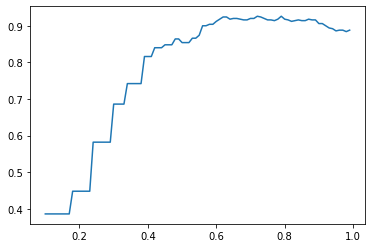

In [60]:
print(np.max(scores), np.arange(0.1, 1, .01)[np.argmax(scores)])
plt.plot(np.arange(0.1, 1, .01), scores)

In [61]:
model = make_pipeline(MinMaxScaler(), PCA(),
                      KNeighborsClassifier())
param_grid = {
    'pca__n_components': np.arange(0.95, 1, .01),
    'kneighborsclassifier__n_neighbors': np.arange(2, 11),
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'minkowski', 'cosine']
}
grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(X_train, y_train)

/home/apinotfound/.virtualenvs/zoidberg-bootstrap/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
180 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/home/apinotfound/.virtualenvs/zoidberg-bootstrap/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/apinotfound/.virtualenvs/zoidberg-bootstrap/lib/python3.8/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/apinotfound/.virtualenvs/zoidberg-bootstrap/lib/pyth

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('pca', PCA()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__metric': ['euclidean',
                                                          'manhattan',
                                                          'minkowski',
                                                          'cosine'],
                         'kneighborsclassifier__n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'pca__n_components': array([0.95, 0.96, 0.97, 0.98, 0.99, 1.  ])})

In [62]:
print(f'GridSearchCV Best parameters: {grid.best_params_}')
print(f'Best estimator score: {grid.best_estimator_.score(X_test, y_test)}')

GridSearchCV Best parameters: {'kneighborsclassifier__metric': 'cosine', 'kneighborsclassifier__n_neighbors': 3, 'pca__n_components': 0.95}
Best estimator score: 0.92


In [63]:
X_train_filtered = X_train[no_outliers]
y_train_filtered = y_train[no_outliers]

In [64]:
model = make_pipeline(MinMaxScaler(), PCA(),
                      KNeighborsClassifier())
param_grid = {
    'pca__n_components': np.arange(0.95, 1, .01),
    'kneighborsclassifier__n_neighbors': np.arange(2, 11),
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'minkowski', 'cosine']
}
grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(X_train_filtered, y_train_filtered)

/home/apinotfound/.virtualenvs/zoidberg-bootstrap/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
180 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/home/apinotfound/.virtualenvs/zoidberg-bootstrap/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/apinotfound/.virtualenvs/zoidberg-bootstrap/lib/python3.8/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/apinotfound/.virtualenvs/zoidberg-bootstrap/lib/pyth

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('pca', PCA()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__metric': ['euclidean',
                                                          'manhattan',
                                                          'minkowski',
                                                          'cosine'],
                         'kneighborsclassifier__n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'pca__n_components': array([0.95, 0.96, 0.97, 0.98, 0.99, 1.  ])})

In [65]:
print(f'GridSearchCV Best parameters: {grid.best_params_}')
print(f'Best estimator score: {grid.best_estimator_.score(X_test, y_test)}')

GridSearchCV Best parameters: {'kneighborsclassifier__metric': 'cosine', 'kneighborsclassifier__n_neighbors': 3, 'pca__n_components': 0.96}
Best estimator score: 0.91
